In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from convolution import window_mask, find_window_centroids
from sliding_window import fit_polynomial, find_lane_pixels
from radius_curve import measure_curvature_real
from threshold import *
from prev_ploy import search_around_poly
cmt, diss = np.load('./cmx_dist.npy')
M, Minv = np.load('./M_Minv.npy')

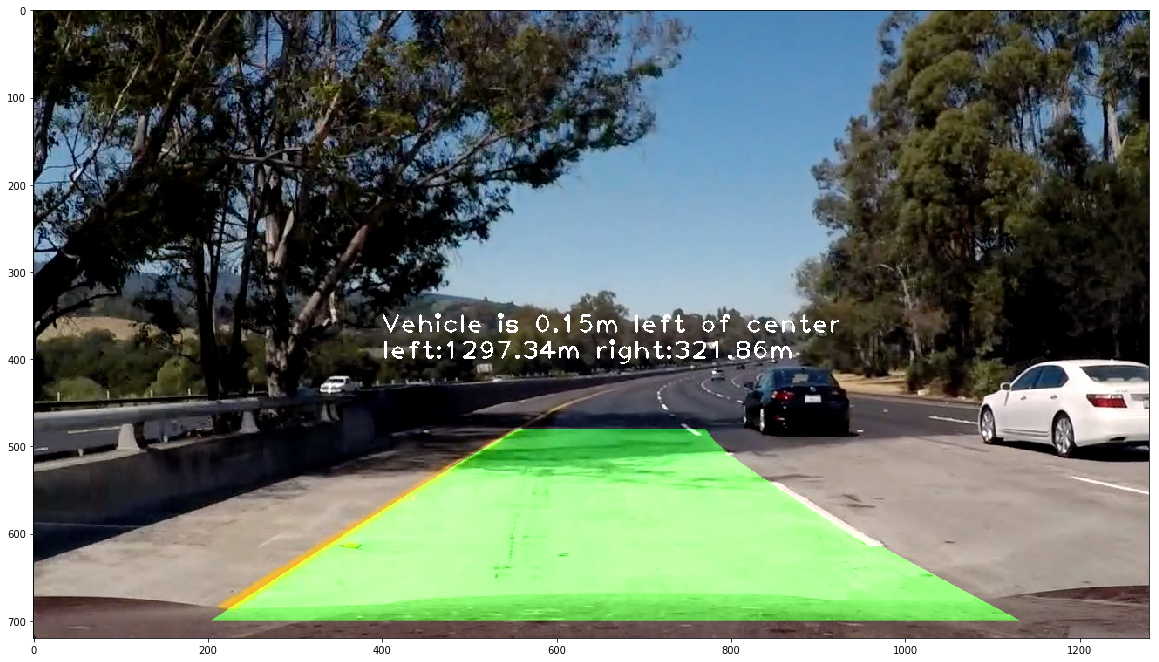

In [2]:
first_image = True
def pipeline(img):
    original_img = img
    img = cv2.warpPerspective(cv2.undistort(img, cmt, diss), M, (1280, 720))
    img = threshold(img)
    global first_image
    if first_image:
        left_fit, right_fit = find_lane_pixels(img)
        fist_image = False
    leftx, rightx, ploty = search_around_poly(img, left_fit, right_fit)
    
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (1280, 720))
    img = cv2.addWeighted(original_img, 1, newwarp, 0.5, 0)
    
    left_c, right_c, distance = measure_curvature_real(ploty, leftx, rightx)
    cv2.putText(img, "left:{:.2f}m right:{:.2f}m".format(left_c, right_c), 
               (400, 400), 1, 2, (255, 255, 255), 2)
    if distance < 0:
        cv2.putText(img, "Vehicle is {:.2f}m left of center".format(abs(distance)), (400, 370), 1, 2, (255, 255, 255), 2)
    else:
        cv2.putText(img, "Vehicle is {:.2f}m right of center".format(distance), (400, 370), 1, 2, (255, 255, 255), 2)
    return img
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(pipeline(cv2.imread('./test_images/test5.jpg')), cv2.COLOR_BGR2RGB))
plt.savefig('distance.jpg', bbox_inches='tight')

In [3]:
fist_image = True
project_video = './project_video.mp4'
clip = VideoFileClip(project_video)
white_clip = clip.fl_image(image_func=pipeline)
white_clip.write_videofile('project_test.mp4', audio=False, preset='ultrafast')

[MoviePy] >>>> Building video project_test.mp4
[MoviePy] Writing video project_test.mp4


100%|█████████▉| 1260/1261 [04:39<00:00,  4.51it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_test.mp4 



In [4]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_test.mp4'))